<class 'dgl.heterograph.DGLHeteroGraph'>
45


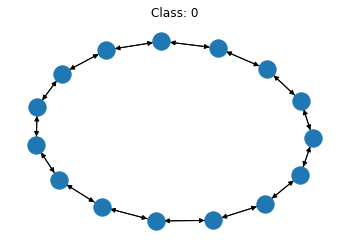

In [2]:
### Source Tutorial: https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html

"""
.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).

"""

###############################################################################
# Simple graph classification task
# --------------------------------
# In this tutorial, you learn how to perform batched graph classification
# with DGL. The example task objective is to classify eight types of topologies shown here.
#
# .. image:: https://data.dgl.ai/tutorial/batch/dataset_overview.png
#     :align: center
#
# Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
# different types of graphs and each class has the same number of graph samples.

from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
print(type(graph))
print(graph.number_of_edges())
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()


In [3]:

###############################################################################
# Form a graph mini-batch
# -----------------------
# To train neural networks efficiently, a common practice is to batch
# multiple samples together to form a mini-batch. Batching fixed-shaped tensor
# inputs is common. For example, batching two images of size 28 x 28
# gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs
# has two challenges:
#
# * Graphs are sparse.
# * Graphs can have various length. For example, number of nodes and edges.
#
# To address this, DGL provides a :func:`dgl.batch` API. It leverages the idea that
# a batch of graphs can be viewed as a large graph that has many disjointed 
# connected components. Below is a visualization that gives the general idea.
#
# .. image:: https://data.dgl.ai/tutorial/batch/batch.png
#     :width: 400pt
#     :align: center
#
# Define the following ``collate`` function to form a mini-batch from a given
# list of graph and label pairs.

import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    new_samples = []
    for graph, _ in samples:
        # Rather than the number of nodes, the labels changed to number of edges
        new_samples.append((graph, torch.tensor(float(graph.number_of_edges()))))
    graphs, labels = map(list, zip(*new_samples))
     
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [4]:
# Looking at the trainset data to see if the labels match

trainset = MiniGCDataset(320, 10, 20)
graph, label = collate(trainset)
print(trainset[250])
print(label)

(Graph(num_nodes=18, num_edges=324,
      ndata_schemes={}
      edata_schemes={}), tensor(6, dtype=torch.int32))
tensor([ 45.,  30.,  39.,  39.,  51.,  57.,  39.,  45.,  36.,  42.,  51.,  48.,
         54.,  54.,  33.,  48.,  51.,  51.,  54.,  33.,  45.,  57.,  54.,  57.,
         42.,  39.,  30.,  39.,  45.,  30.,  36.,  39.,  54.,  33.,  39.,  39.,
         39.,  51.,  30.,  33.,  55.,  55.,  28.,  40.,  49.,  37.,  34.,  49.,
         34.,  28.,  28.,  40.,  43.,  43.,  46.,  52.,  40.,  31.,  40.,  55.,
         52.,  31.,  31.,  49.,  55.,  55.,  37.,  46.,  49.,  34.,  28.,  37.,
         43.,  55.,  40.,  40.,  46.,  40.,  40.,  37.,  66.,  66.,  86.,  66.,
         61.,  81.,  71.,  71.,  46.,  51.,  71.,  91.,  61.,  46.,  71.,  46.,
         51.,  56.,  66.,  56.,  46.,  61.,  56.,  46.,  81.,  71.,  91.,  46.,
         56.,  81.,  56.,  91.,  56.,  61.,  61.,  56.,  61.,  66.,  51.,  56.,
        237.,  87., 136., 184.,  64.,  70., 202., 136., 127., 142., 142.,  64.,
      

In [5]:
###############################################################################
# Readout and classification
# --------------------------
# For this demonstration, consider initial node features to be their degrees.
# After two rounds of graph convolution, perform a graph readout by averaging
# over all node features for each graph in the batch.
#
# .. math::
#
#    h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}
#
# In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
# graphs with variable size. You then feed the graph representations into a
# classifier with one linear layer to obtain pre-softmax logits.

import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


In [6]:

###############################################################################
# Setup and training
# ------------------
# Create a synthetic dataset of :math:`400` graphs with :math:`10` ~
# :math:`20` nodes. :math:`320` graphs constitute a training set and
# :math:`80` graphs constitute a test set.
import torch.optim as optim
from torch.utils.data import DataLoader
from dgl.nn.pytorch import GraphConv
import numpy as np

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.

# Tunes specific parameters (currently only learning rate and hidden dimensions)
# Outputs the MSE and Epoch losses array
def tuning_round(curr_lr, curr_epoch_range, curr_batch_size):
    # 4/15: Made batch_size to 1
    data_loader = DataLoader(trainset, batch_size=curr_batch_size, shuffle=True,
                             collate_fn=collate)

    # Create model
    #modified to contain a single output
    #model = Classifier(1, 256, trainset.num_classes)
    #TODO: need to train hyperparameters hidden layers
    # hidden_dim = 256
    model = Classifier(1, 256, 1)
    loss_func = nn.MSELoss()

    #modifications to migrate to regression
    #loss_func = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=curr_lr)
    model.train()

    epoch_losses = [] # MSE average list
    epoch_r_losses = [] # RMSE average list
    for epoch in range(curr_epoch_range):
        epoch_loss = 0
        epoch_r_loss = 0
        for iter, (bg, label) in enumerate(data_loader):
            prediction = model(bg)
            loss = loss_func(prediction, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            MRE_loss = np.average(np.abs(np.array(prediction.detach().numpy()) - np.array(label.detach().numpy()))/np.abs(np.array(label.detach().numpy())))
            # Make sure the labels are normal and not irregularly high
            epoch_loss += loss.detach().item()
            if np.isinf(MRE_loss):
                # Occurs when one of the label values is zero
#                 fig, ax = plt.subplots()
#                 nx.draw(graph.to_networkx(), ax=ax)
#                 print("example graph:")
#                 plt.show()
#                 print(graph)
#                 print(label)
                continue
            print(MRE_loss)
            
            
            epoch_r_loss += MRE_loss
        epoch_loss /= (iter + 1)
        epoch_r_loss /= (iter + 1)

#         print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
#         print(prediction)
#         print(np.array(prediction.detach().numpy()) - np.array(label.detach().numpy()))
#         print(loss)
#         curr_MSE = np.average(np.abs(np.array(prediction.detach().numpy()) - np.array(label.detach().numpy()))/abs(np.array(label.detach().numpy())))
#         MSE.append(curr_MSE)

        epoch_losses.append(epoch_loss)
        epoch_r_losses.append(epoch_r_loss)
    return epoch_losses, epoch_r_losses

In [7]:
# Tuning Learning Rate
# TODO: grid searching for all the hyperparameters
mse_lr_arr = []
rmse_lr_arr = []
curr_epoch_size = 80
curr_batch_size = 32
for i in [0.01, 0.001, 0.0005, 0.0001]:
    print(i)
    epoch_losses_arr, epoch_r_losses_arr = tuning_round(i, curr_epoch_size, curr_batch_size)
    mse_lr = sum(epoch_losses_arr)/len(epoch_losses_arr)
    rmse_lr = sum(epoch_r_losses_arr)/len(epoch_r_losses_arr)
    mse_lr_arr.append(mse_lr)
    rmse_lr_arr.append(rmse_lr)
print(mse_lr_arr)
print(rmse_lr_arr)


# Find best learning rate and graph the MSE and RMSE

0.01


C:\Users\wings\anaconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\wings\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0.001
0.0005
0.0001
[5013.000291519167, 4939.444183654784, 5084.235572814943, 5218.373687286377]
[68.63090517520902, 68.5671394753456, 69.42263496875762, 70.43224290132522]


5121.602647460938
69.44024775695799


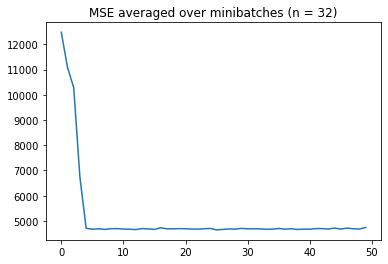

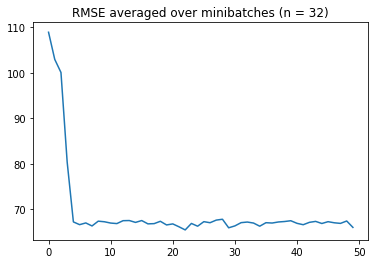

In [11]:
epoch_losses_arr, epoch_r_losses_arr = tuning_round(0.001, 50, 32)
mse_lr = sum(epoch_losses_arr)/len(epoch_losses_arr)
rmse_lr = sum(epoch_r_losses_arr)/len(epoch_r_losses_arr)
print(mse_lr)
print(rmse_lr)

plt.title('MSE averaged over minibatches (n = 32)')
plt.plot(epoch_losses_arr)
plt.show()


plt.title('RMSE averaged over minibatches (n = 32)')
plt.plot(epoch_r_losses_arr)
plt.show()

In [49]:

###############################################################################
# The learning curve of a run is presented below.

# plt.title('cross entropy averaged over minibatches')
# plt.plot(epoch_losses)
#plt.show()

###############################################################################
# The trained model is evaluated on the test set created. To deploy
# the tutorial, restrict the running time to get a higher
# accuracy (:math:`80` % ~ :math:`90` %) than the ones printed below.
testset = MiniGCDataset(20, 10, 20)
model.eval()

# Convert a list of tuples to two lists
new_samples = []
for graph, _ in testset:
    new_samples.append((graph, torch.tensor(float(graph.number_of_edges()))))
test_X, test_Y = map(list, zip(*new_samples))

# test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
print(test_Y)

# probs_Y = torch.softmax(model(test_bg), 1)
probs_Y = model(test_bg)
print(probs_Y)
total_sum = 0
for i, r in enumerate(test_X):
    total_sum += probs_Y[i][0].item() - r.number_of_edges()
# test_X, test_Y = map(list, zip(*testset))
# # print(model)
# exit()
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
# print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
#     (test_Y == probs_Y.float()).sum().item() / len(test_Y) * 100))
# print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
#     (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

print("MSE: ", np.average(np.abs(np.array(probs_Y.detach().numpy()) - np.array(test_Y.detach().numpy()))/abs(np.array(test_Y.detach().numpy()))))

tensor([[ 45.],
        [ 30.],
        [ 37.],
        [ 37.],
        [ 81.],
        [ 91.],
        [109.],
        [106.],
        [ 80.],
        [ 80.],
        [ 68.],
        [ 28.],
        [289.],
        [289.],
        [ 72.],
        [ 40.],
        [ 56.],
        [ 72.],
        [ 72.],
        [ 72.]])
tensor([[74.3363],
        [74.3363],
        [61.2663],
        [61.2663],
        [64.4156],
        [63.8844],
        [69.0286],
        [68.5445],
        [68.4744],
        [68.4744],
        [71.9507],
        [72.6212],
        [83.5326],
        [83.5326],
        [71.4144],
        [71.4144],
        [71.4144],
        [71.4144],
        [71.4144],
        [71.4144]], grad_fn=<AddmmBackward>)
MSE:  0.4559594
